In [57]:
import os
import sys
import datetime
import random
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm.notebook import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, roc_auc_score


In [58]:
train=pd.read_csv("train.csv")
test=pd.read_csv('test.csv')
sample=pd.read_csv('sample_submission.csv')
original=pd.read_csv('Steel Plates Faults.csv')

In [59]:
train.shape,test.shape,original.shape

((19219, 35), (12814, 28), (1941, 34))

In [60]:
train.head().T

,0,1,2,3,4
id,0.0000,1.0000,2.000000e+00,3.000000e+00,4.0000
X_Minimum,584.0000,808.0000,3.900000e+01,7.810000e+02,1540.0000
X_Maximum,590.0000,816.0000,1.920000e+02,7.890000e+02,1560.0000
Y_Minimum,909972.0000,728350.0000,2.212076e+06,3.353146e+06,618457.0000
Y_Maximum,909977.0000,728372.0000,2.212144e+06,3.353173e+06,618502.0000
Pixels_Areas,16.0000,433.0000,1.138800e+04,2.100000e+02,521.0000
X_Perimeter,8.0000,20.0000,7.050000e+02,1.600000e+01,72.0000
Y_Perimeter,5.0000,54.0000,4.200000e+02,2.900000e+01,67.0000
Sum_of_Luminosity,2274.0000,44478.0000,1.311391e+06,3.202000e+03,48231.0000
Minimum_of_Luminosity,113.0000,70.0000,2.900000e+01,1.140000e+02,82.0000


In [61]:
original.head().T

,0,1,2,3,4
X_Minimum,42.0000,6.450000e+02,8.290000e+02,853.0000,1289.0000
X_Maximum,50.0000,6.510000e+02,8.350000e+02,860.0000,1306.0000
Y_Minimum,270900.0000,2.538079e+06,1.553913e+06,369370.0000,498078.0000
Y_Maximum,270944.0000,2.538108e+06,1.553931e+06,369415.0000,498335.0000
Pixels_Areas,267.0000,1.080000e+02,7.100000e+01,176.0000,2409.0000
X_Perimeter,17.0000,1.000000e+01,8.000000e+00,13.0000,60.0000
Y_Perimeter,44.0000,3.000000e+01,1.900000e+01,45.0000,260.0000
Sum_of_Luminosity,24220.0000,1.139700e+04,7.972000e+03,18996.0000,246930.0000
Minimum_of_Luminosity,76.0000,8.400000e+01,9.900000e+01,99.0000,37.0000
Maximum_of_Luminosity,108.0000,1.230000e+02,1.250000e+02,126.0000,126.0000


In [62]:
train=pd.concat([train.drop(columns=['id'],axis=1),original],axis=0)

In [243]:
train.shape

(21160, 55)

In [63]:
target_cols=train.iloc[:,-7:].columns.tolist()
target_cols

['Pastry',
 'Z_Scratch',
 'K_Scatch',
 'Stains',
 'Dirtiness',
 'Bumps',
 'Other_Faults']

## Feature Engineering

In [64]:
def feat_eng(df):
    df["X_center"]= (df["X_Minimum"]+df["X_Maximum"])/2
    df["Y_center"]= (df["Y_Minimum"]+df["Y_Maximum"])/2
    df["elongation_index"]=(df['Y_Maximum']-df['Y_Minimum'])/abs(((df['X_Maximum']-df['X_Minimum'])+1e-8))
    df["Rectangularity"]=df["Pixels_Areas"]/(((df["X_Maximum"] - df["X_Minimum"]) * (df["Y_Maximum"] - df["Y_Minimum"]))+1e-8)
    df["Normalized X_Center"]=((df["X_Minimum"]+df["X_Maximum"])/2)/(df["Length_of_Conveyer"]+1e-8)
    df["Normalized Y_Center"]=((df["Y_Minimum"]+df["Y_Maximum"])/2)/(df["Steel_Plate_Thickness"]+1e-8)
    df["Perimeter InteractionA300"]=(df["X_Perimeter"]/(df["Y_Perimeter"])*df["TypeOfSteel_A300"]+1e-8)
    df["Perimeter InteractionA400"]=(df["X_Perimeter"]/(df["Y_Perimeter"])*df["TypeOfSteel_A400"]+1e-8)
    df["log_XtoY_perimeter"]=np.log(df["X_Perimeter"]/df["Y_Perimeter"])
    df["PixelArea_to_Thickness"]=np.log(df["Pixels_Areas"] / (df["Steel_Plate_Thickness"]+1e-8))
    df["Normalized Area"]=df["Pixels_Areas"]/((df["Length_of_Conveyer"]*df["Steel_Plate_Thickness"])+1e-8)
    df["Luminosity Contrast"]=(df["Maximum_of_Luminosity"]-df["Minimum_of_Luminosity"])/(df["Sum_of_Luminosity"]+1e-8)
    df["Density"]=df["Pixels_Areas"]/(((df["X_Maximum"]-df["X_Minimum"])*(df["Y_Maximum"]-df["Y_Minimum"]))+1e-8)
    df["Thickness&Luminosity"]=df["Steel_Plate_Thickness"]* (df["Sum_of_Luminosity"]+1e-8)
    df["Edge_Density"]=(df["Edges_X_Index"]+df["Edges_Y_Index"])/(df["Pixels_Areas"]+1e-8)
    df['Spatial_Distribution_Index'] = df['Edges_Index']+df['Empty_Index']+df['Square_Index']+df['Outside_X_Index']+df['Edges_X_Index']+df['Edges_Y_Index']+df['Outside_Global_Index']
    df['_Color_Range']=df['Maximum_of_Luminosity']-df['Minimum_of_Luminosity']
    df['_Compactness_X']=df['Pixels_Areas']/(df['X_Perimeter']**2)
    df['_Compactness_Y']=df['Pixels_Areas']/(df['Y_Perimeter']**2)
    df['_Normalized_Luminosity_Index'] = df['Luminosity_Index'] / (df['Pixels_Areas']+1e-8)
    df['_Thickness_Steel_Type'] = df['Steel_Plate_Thickness']*(df['TypeOfSteel_A300']+df['TypeOfSteel_A400'])
    return df

In [65]:
feat_eng(train)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Luminosity Contrast,Density,Thickness&Luminosity,Edge_Density,Spatial_Distribution_Index,_Color_Range,_Compactness_X,_Compactness_Y,_Normalized_Luminosity_Index,_Thickness_Steel_Type
0,584,590,909972,909977,16,8,5,2274,113,140,...,0.011873,0.533333,1.137000e+05,0.125000,3.6452,27,0.250000,0.640000,-0.000650,50
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.000922,2.460227,3.558240e+06,0.002887,3.5775,41,1.082500,0.148491,-0.000692,80
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.000085,1.094579,5.245564e+07,0.000055,2.3031,112,0.022912,0.064558,-0.000008,40
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.006246,0.972222,1.280800e+05,0.006219,3.6972,20,0.820312,0.249703,-0.000191,40
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.000601,0.578889,1.446930e+07,0.002297,2.9558,29,0.100502,0.116061,-0.000471,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,0.000628,0.609375,1.401320e+06,0.004563,2.5946,22,0.093621,0.564050,0.000010,40
1937,144,175,340581,340598,287,44,24,34599,112,133,...,0.000607,0.544592,1.383960e+06,0.004923,2.6513,21,0.148244,0.498264,-0.000203,40
1938,145,174,386779,386794,292,40,22,37572,120,140,...,0.000532,0.671264,1.502880e+06,0.004818,2.4872,20,0.182500,0.603306,0.000018,40
1939,137,170,422497,422528,419,97,47,52715,117,140,...,0.000436,0.409580,2.108600e+06,0.002386,2.7554,23,0.044532,0.189679,-0.000041,40


In [66]:
feat_eng(test)

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Luminosity Contrast,Density,Thickness&Luminosity,Edge_Density,Spatial_Distribution_Index,_Color_Range,_Compactness_X,_Compactness_Y,_Normalized_Luminosity_Index,_Thickness_Steel_Type
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,...,0.000962,1.525463,9.353550e+06,0.002375,3.7793,60,1.245747,0.311437,-0.000343,150
1,19220,1257,1271,419960,419973,370,26,28,39293,92,...,0.001018,2.032967,1.571720e+06,0.003355,2.9164,40,0.547337,0.471939,-0.000393,40
2,19221,1358,1372,117715,117724,289,36,32,29386,101,...,0.001123,2.293651,1.175440e+06,0.004671,2.5260,33,0.222994,0.282227,-0.000151,40
3,19222,158,168,232415,232440,80,10,11,8586,107,...,0.003843,0.320000,8.586000e+05,0.022500,4.3991,33,0.800000,0.661157,-0.000922,100
4,19223,559,592,544375,544389,140,19,15,15524,103,...,0.001997,0.303030,9.314400e+05,0.009824,2.9008,31,0.387812,0.622222,-0.000639,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,32028,1101,1116,447943,447992,313,32,37,21603,79,...,0.001111,0.425850,1.512210e+06,0.004235,3.1625,24,0.305664,0.228634,-0.000993,70
12810,32029,1289,1306,3149494,3149542,59,9,18,5249,113,...,0.005334,0.072304,2.099600e+05,0.030132,3.3492,28,0.728395,0.182099,-0.000759,40
12811,32030,41,210,1587535,1587191,16584,796,522,1858162,24,...,0.000064,-0.285262,7.432648e+07,0.000038,2.3104,119,0.026174,0.060862,-0.000005,40
12812,32031,1329,1340,702237,702267,386,43,34,36875,66,...,0.001573,1.169697,1.475000e+06,0.003214,2.5988,58,0.208761,0.333910,-0.000681,40


In [67]:
X=train.drop(columns=target_cols,axis=1)
y=train.loc[:,target_cols]

In [68]:
X.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Luminosity Contrast,Density,Thickness&Luminosity,Edge_Density,Spatial_Distribution_Index,_Color_Range,_Compactness_X,_Compactness_Y,_Normalized_Luminosity_Index,_Thickness_Steel_Type
0,584,590,909972,909977,16,8,5,2274,113,140,...,0.011873,0.533333,1.137000e+05,0.125000,3.6452,27,0.250000,0.640000,-0.000650,50
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.000922,2.460227,3.558240e+06,0.002887,3.5775,41,1.082500,0.148491,-0.000692,80
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.000085,1.094579,5.245564e+07,0.000055,2.3031,112,0.022912,0.064558,-0.000008,40
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.006246,0.972222,1.280800e+05,0.006219,3.6972,20,0.820312,0.249703,-0.000191,40
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.000601,0.578889,1.446930e+07,0.002297,2.9558,29,0.100502,0.116061,-0.000471,300


In [69]:
y.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1


## Creating DataLoaders

In [71]:
# splitting data
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=17)

# Standardizing Data
std_scaler=StandardScaler()
X_train_scaled=std_scaler.fit_transform(X_train)
X_val_scaled=std_scaler.transform(X_val)

# creating tensors
X_train_tensor,y_train_tensor=torch.as_tensor(X_train_scaled,dtype=torch.float32),torch.as_tensor(y_train.values,dtype=torch.float32)
X_val_tensor,y_val_tensor=torch.as_tensor(X_val_scaled,dtype=torch.float32),torch.as_tensor(y_val.values,dtype=torch.float32)


In [77]:
class TabularData(Dataset):
    def __init__(self,x_tensor,y_tensor):
        self.x=x_tensor
        self.y=y_tensor

    def __getitem__(self, index):
        return (self.x[index],self.y[index])
    
    def __len__(self):
        return len(self.x)

        

In [78]:
train_dataset=TabularData(X_train_tensor,y_train_tensor)
val_dataset=TabularData(X_val_tensor,y_val_tensor)

train_loader=DataLoader(train_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=256,num_workers=4,pin_memory=True)


## Create Model Training class

In [280]:
class AllShitsHere(object):
    def __init__(self,model,loss_fn,optimizer):
        # arguments
        self.model=model
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.device='cuda:0' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        # to be used in future (Cuerrently empty)
        self.train_loader=None
        self.val_loader=None

        # computes internally
        self.losses=[]
        self.val_losses=[]
        self.total_epochs=0
        self.scores=[]
        self.val_scores=[]

        # step functions
        self.train_step_fn=self._make_train_step_fn()
        self.val_step_fn=self._make_val_step_fn()

    def to(self,device):
        try:
            self.device=device
            self.model.to(self.device)
        except RuntimeError:
            self.device='cuda:0' if torch.cuda.is_available else 'cpu'
            print(f"Can't send to {device}, moving to {self.device} instead!")
            self.model.to(self.device)

    def set_loaders(self,train_loader,val_loader=None):
        self.train_loader=train_loader
        self.val_loader=val_loader

    def calculate_scores(self,yhat,y):
        scores_per_epoch=[]
        for i in range(7):
            try:
                score=roc_auc_score(y[:,i].detach().cpu().numpy(),yhat[:,i].detach().cpu().numpy(),multi_class='ovo',average='weighted')
                scores_per_epoch.append(score)
            except ValueError:
                score=0.5
                scores_per_epoch.append(score)
        return np.mean(scores_per_epoch)

    def _make_train_step_fn(self):
        def perform_train_step_fn(X,y):
            # set model to train mode
            self.model.train()
            # forward pass
            yhat=self.model(X)
            # calculate scores
            train_score=self.calculate_scores(yhat,y)
            # calculate loss
            loss=self.loss_fn(yhat,y)
            # compute gradients
            loss.backward()
            # update parameters
            self.optimizer.step()
            self.optimizer.zero_grad()

            
            return loss.item(),train_score
        return perform_train_step_fn

    def _make_val_step_fn(self):
        def perform_val_step(X,y):
            # set model to eval mode
            self.model.eval()
            # forward pass
            yhat=self.model(X)
            # scores claculation
            val_score=self.calculate_scores(yhat,y)
            # loss calculation
            loss=self.loss_fn(yhat,y)


            return loss.item(),val_score
        return perform_val_step
    
    def _mini_batch(self,validation=False):
        if validation:
            data_loader=self.val_loader
            step_fn=self.val_step_fn

        else:
            data_loader=self.train_loader
            step_fn=self.train_step_fn

        if data_loader is None:
            return None
        
        mini_batch_losses=[]
        mini_batch_scores=[]
        for X_batch,y_batch in data_loader:
            X_batch=X_batch.to(self.device)
            y_batch=y_batch.to(self.device)

            mini_batch_loss,mini_batch_score=step_fn(X_batch,y_batch)
            mini_batch_losses.append(mini_batch_loss)
            mini_batch_scores.append(mini_batch_score)


        return np.mean(mini_batch_losses),np.mean(mini_batch_scores)
    
    def set_seed(self,seed=42):
        torch.backends.cudnn.deterministic=True
        torch.backends.cudnn.benchmark=False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self,n_epochs,seed=42):
        self.set_seed(seed)
        for epoch in tqdm(range(n_epochs)):
            self.total_epochs+=1
            # perform training using mini batches
            loss,train_score=self._mini_batch(validation=False)
            self.scores.append(train_score)
            self.losses.append(loss)

            # perform validation using mini batches
            with torch.no_grad():
                val_loss,val_score=self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
                self.val_scores.append(val_score)

    def predict(self,X):
        self.model.eval()
        X_tensor=torch.as_tensor(X,dtype=torch.float32,device=self.device)
        self.model.train()
        yhat_tensor=self.model(X_tensor)
        return yhat_tensor.detach().cpu().numpy()
    
    def plot_figures(self):
        fig,axes=plt.subplots(1,2,figsize=(10,4))
        axes[0].plot(self.losses,label='training loss',c='b')
        axes[0].plot(self.val_losses,label='validation loss',c='r')
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("Losses")

        axes[1].plot(self.scores,label='training score',c='b')
        axes[1].plot(self.val_scores,label='validation score',c='r')
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("AUC-ROC")


        axes[0].legend()
        axes[1].legend()
        plt.tight_layout()
        plt.show()
        





## Create Model Class

In [281]:
class TabularNet(nn.Module):
    def __init__(self,p,input_shape,output_shape):
        super(TabularNet,self).__init__()
        self.p=p
        self.input_shape=input_shape
        self.output_shape=output_shape

        self.feature_extractor=nn.Sequential(
            nn.Linear(input_shape,384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout(self.p),
            
            nn.Linear(384,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(self.p),
            
            nn.Linear(1024,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(self.p),
            
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.p),
            
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(self.p))
        
        self.classifier=nn.Sequential(
            nn.Linear(32,output_shape),
            nn.Sigmoid())
        
    def forward(self,x):
        x=self.feature_extractor(x)
        x=self.classifier(x)
        return x
        
        
        
          

## Model Training

In [282]:
model=TabularNet(p=0.3,input_shape=48,output_shape=7)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_fn=nn.BCELoss(reduction='mean')

In [283]:
summary(model,input_size=(256,48))

Layer (type:depth-idx)                   Output Shape              Param #
TabularNet                               [256, 7]                  --
├─Sequential: 1-1                        [256, 32]                 --
│    └─Linear: 2-1                       [256, 384]                18,816
│    └─BatchNorm1d: 2-2                  [256, 384]                768
│    └─ReLU: 2-3                         [256, 384]                --
│    └─Dropout: 2-4                      [256, 384]                --
│    └─Linear: 2-5                       [256, 1024]               394,240
│    └─BatchNorm1d: 2-6                  [256, 1024]               2,048
│    └─ReLU: 2-7                         [256, 1024]               --
│    └─Dropout: 2-8                      [256, 1024]               --
│    └─Linear: 2-9                       [256, 128]                131,200
│    └─BatchNorm1d: 2-10                 [256, 128]                256
│    └─ReLU: 2-11                        [256, 128]               

In [284]:
AnuwazNet=AllShitsHere(model,loss_fn,optimizer)
AnuwazNet.set_loaders(train_loader,val_loader)


In [285]:
AnuwazNet.train(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [286]:
# AnuwazNet.calculate_scores(torch.tensor([[0.001,0.023,0.0045,0.0221,0.849,0.121,0.759],
#                                          [0.877,0.0012,0.0078,0.675,0.0064,0.210,0.000142]]),
#                                          torch.tensor([[1,0,0,0,1,0,1],[1,0,0,1,0,0,0]]))


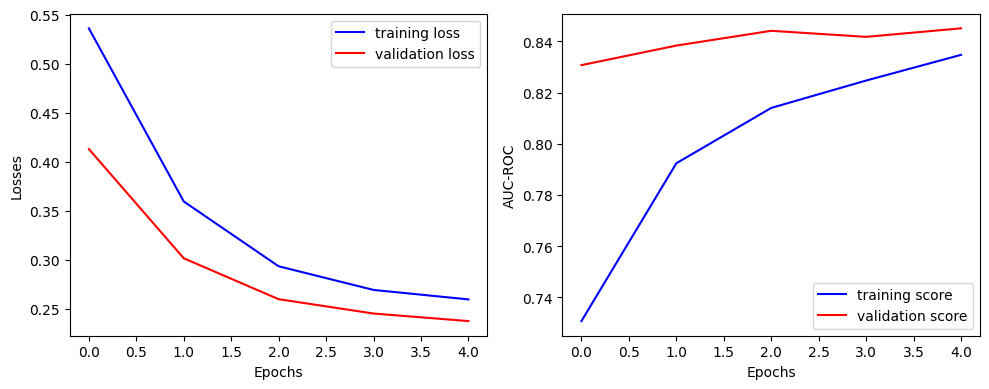

In [287]:
AnuwazNet.plot_figures()

In [223]:
np.sum(np.array([12,3,4,5,np.nan]))

nan

In [203]:
AnuwazNet.val_losses.index(min(AnuwazNet.val_losses))

4

In [146]:
preds=AnuwazNet.predict(std_scaler.transform(test.drop(columns=['id'])))

In [147]:
for i,col in enumerate(target_cols):
    sample[col]=preds[:,i]

sample.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.328386,0.036604,0.004718,0.000304,0.009540,0.168590,0.507825
1,19220,0.340745,0.012706,0.004816,0.001129,0.024902,0.161500,0.384328
2,19221,0.003048,0.035500,0.012388,0.000565,0.003601,0.343120,0.569431
3,19222,0.044745,0.005219,0.000711,0.000176,0.002600,0.476292,0.351082
4,19223,0.006141,0.000225,0.000751,0.000026,0.000664,0.724104,0.261877


In [135]:
sample.to_csv("torch_baseline_mixed.csv",index=False)

# Start Prototyping

In [288]:
def make_data_loader(X_train,X_val,y_train,y_val):

    # Standardizing Data
    std_scaler=StandardScaler()
    X_train_scaled=std_scaler.fit_transform(X_train)
    X_val_scaled=std_scaler.transform(X_val)

    # creating tensors
    X_train_tensor,y_train_tensor=torch.as_tensor(X_train_scaled,dtype=torch.float32),torch.as_tensor(y_train.values,dtype=torch.float32)
    X_val_tensor,y_val_tensor=torch.as_tensor(X_val_scaled,dtype=torch.float32),torch.as_tensor(y_val.values,dtype=torch.float32)

    train_dataset=TabularData(X_train_tensor,y_train_tensor)
    val_dataset=TabularData(X_val_tensor,y_val_tensor)

    train_loader=DataLoader(train_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=True)
    val_loader=DataLoader(val_dataset,batch_size=256,num_workers=4,pin_memory=True)

    return train_loader,val_loader

In [305]:
from sklearn.model_selection import StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf=MultilabelStratifiedKFold(n_splits=5,shuffle=True,random_state=42)

all_predictions=[]
final_mean_scores=[]
# perform cross validation
for train_idx, val_idx in mskf.split(X,y):
    X_train,y_train=X.iloc[train_idx],y.iloc[train_idx]
    X_val,y_val=X.iloc[val_idx],y.iloc[val_idx]

    train_loader,val_loader=make_data_loader(X_train,X_val,y_train,y_val)

    model=TabularNet(p=0.3,input_shape=48,output_shape=7)
    optimizer=optim.Adam(model.parameters(),lr=3e-4)
    loss_fn=nn.BCELoss(reduction='mean')

    AnuwazNet=AllShitsHere(model,loss_fn,optimizer)
    AnuwazNet.set_loaders(train_loader,val_loader)
    AnuwazNet.train(20)
    print(f"Min val loss: {np.min(AnuwazNet.val_losses)}\tFinal val loss: {np.mean(AnuwazNet.val_losses)}")
    preds=AnuwazNet.predict(std_scaler.transform(test.drop(columns=['id'])))
    all_predictions.append(preds)
    final_mean_scores.append(AnuwazNet.val_scores[-3:])

print(np.mean(final_mean_scores))


  0%|          | 0/20 [00:00<?, ?it/s]

Min val loss: 0.23786377731491537	Final val loss: 0.3037684014614891


  0%|          | 0/20 [00:00<?, ?it/s]

Min val loss: 0.2361435732420753	Final val loss: 0.3247775111566572


  0%|          | 0/20 [00:00<?, ?it/s]

Min val loss: 0.2338657913839116	Final val loss: 0.32276488367248984


  0%|          | 0/20 [00:00<?, ?it/s]

Min val loss: 0.23549323835793665	Final val loss: 0.3250072126879412


  0%|          | 0/20 [00:00<?, ?it/s]

Min val loss: 0.23300794117590962	Final val loss: 0.32262119330904054
0.8466185102827064


In [292]:
# def output(pred_list):
#     pred_array=np.array(pred_list)
#     pred_array_mean=np.mean(pred_array,axis=0)

#     for i,col in enumerate(target_cols):
#         sample[col]=pred_array_mean[:,i]

#     return sample